In [12]:
import os
import pandas as pd
import numpy as np

from scipy.optimize import fmin
from scipy.io import loadmat
from scipy import stats

import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox

import time
from src.tools import *
from src.econometric_model import *
from src.Econometrics import *
from src.likehood import *
from src.skew_t import *
from src.model import *
from src.Statistics import *
cwd = os.getcwd()

In [13]:
np_CDS_data = pd.read_excel(f'{cwd}/data/CLEAN_CDX NA IG Serie 17 data.xlsx', header=None).to_numpy()
df_CDS_data = pd.read_excel(f'{cwd}/data/CLEAN_CDX NA IG Serie 17.xlsx', index_col=0)
df_CDS_data.index.name = 'Dates'
df_Dates =  pd.DataFrame(df_CDS_data.index)


In [14]:

df_Dates =  pd.DataFrame(df_CDS_data.index)
df_Dates = df_Dates.rename(columns={'Serie 17': 'Dates'})

df_LogDiff_CDS = pd.DataFrame(np.diff(np.log(np.transpose(np_CDS_data))).transpose())
df_LogDiff_CDS.index = pd.to_datetime(df_Dates['Dates'].drop(0, axis=0))
df_LogDiff_CDS.columns = df_CDS_data.columns


df_CDS_data_mean, df_LogDiff_CDS_mean = get_graph_data(df_CDS_data,df_LogDiff_CDS)


df_Summary_Stat_CDS = get_Stat_Summary(df_CDS_data)
df_CDS_Stats = get_Stat(df_CDS_data)

df_LogDiff_Stats = get_Stat(df_LogDiff_CDS)
df_Summary_Stat_AvgDiff = get_Stat_Summary(df_LogDiff_CDS)
df_LogDiff_CDS_Sqrd =df_LogDiff_CDS**2

# Apply the adfuller_test & and LB_test
adf_results = df_CDS_data.apply(adfuller_test) # Test CDS data 
adf_resultsAvg = df_LogDiff_CDS.apply(adfuller_test) # Test Log diff of data
ljung_box_results = df_LogDiff_CDS.apply(ljung_box_test)
ljung_box_results_sqrd = df_LogDiff_CDS_Sqrd.apply(ljung_box_test)

position = ljung_box_results_sqrd[ljung_box_results_sqrd < 0.05].count()
position

55

In [ ]:
df_Summary_Stat_CDS.to_excel(r'./data/Summary Stats CDS.xlsx')
df_Summary_Stat_AvgDiff.to_excel(r'./data/Summary Stats LogDiff CDS.xlsx')

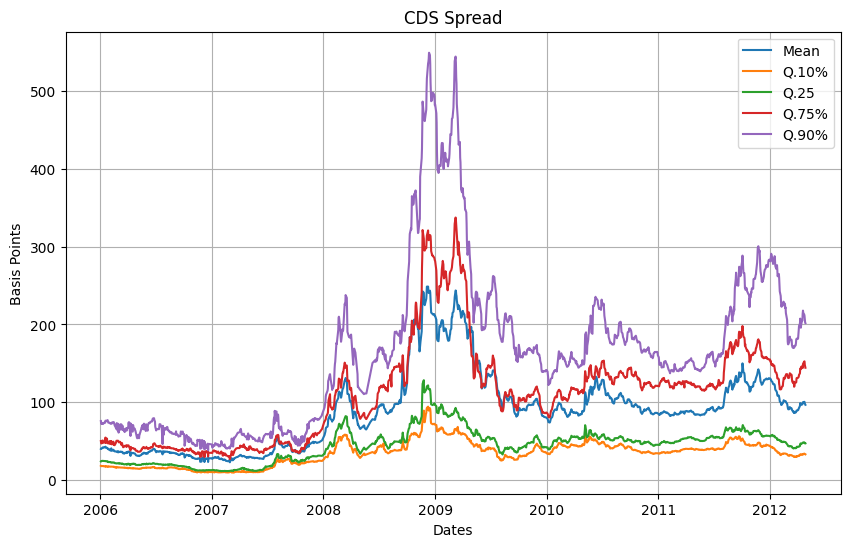

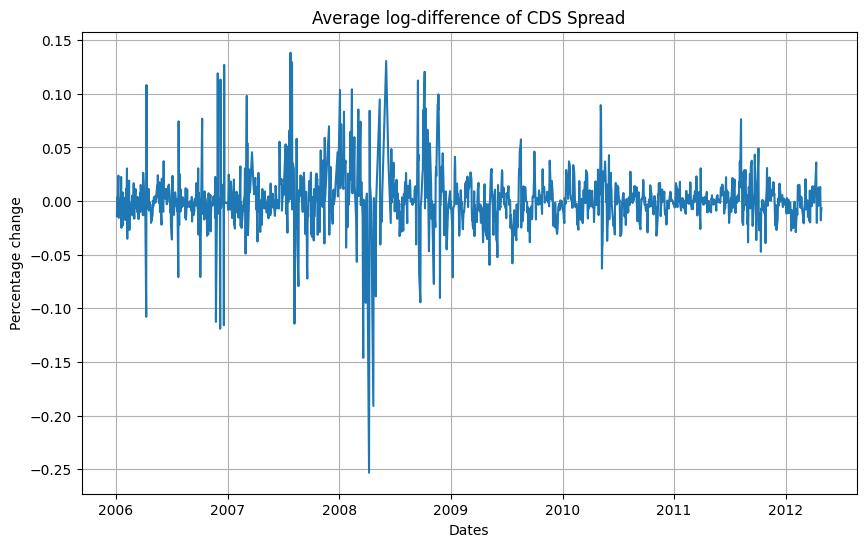

In [15]:

plt.figure(figsize=(10, 6))

plt.plot(df_CDS_data_mean.index, df_CDS_data_mean)
plt.title('CDS Spread')
plt.xlabel(df_CDS_data_mean.index.name)
plt.ylabel('Basis Points')
plt.legend(df_CDS_data_mean.columns) 
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))

plt.plot(df_LogDiff_CDS_mean.index,df_LogDiff_CDS_mean)

plt.title('Average log-difference of CDS Spread')
plt.xlabel(df_LogDiff_CDS_mean.index.name)
plt.ylabel('Percentage change')
plt.grid(True)
plt.show()

### AR(5) Model for log diff of CDS Spreads

In [ ]:
Log_Diff_Model = AR_Model(df_LogDiff_CDS,5,df_LogDiff_CDS_mean)
Log_Diff_Model.fit_models()
Log_Diff_Model.residuals

Log_Diff_Model.residuals = pd.DataFrame(Log_Diff_Model.residuals, index=Log_Diff_Model.results_Coef.index).transpose()
res_mean = get_Stat(Log_Diff_Model.results_Coef)
res_mean = res_mean.set_index(Log_Diff_Model.results_Coef.index)


In [20]:
res_mean.to_excel(r'./data/Summary Stats Model.xlsx')

### AR(5) Model for log diff of Market

In [11]:
Market_Model = AutoReg(
        endog = df_LogDiff_CDS_mean, 
        lags= 5,
        )
Results_Market = Market_Model.fit()


C:\Users\ayman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
df_LogDiff_CDS['CAIG1U5 INDEX'].to_frame()

In [ ]:
garch = GJRGARCH(df_LogDiff_CDS['CAIG1U5 INDEX'].to_frame(),Results_Market.resid.to_frame(),1)
garch.fit()

In [ ]:
print(res.summary())
fig = plt.figure(figsize=(16, 9))
fig = res.plot_diagnostics(fig=fig, lags=30)

In [ ]:
sel = ar_select_order(df_LogDiff_CDS['CAIG1U5 INDEX'], 13, exog=df_LogDiff_CDS_mean.to_frame(name='Market'), old_names=False)
sel.ar_lags

In [ ]:
df_LogDiff_CDS.columns[0]
df_LogDiff_CDS_mean

In [ ]:
Stat_CDS = stats.describe(np_CDS_data)
Stat_logDiff_CDS = stats.describe(np_CDS_data)

# stats.describe(Stat_CDS.mean)
Market = pd.DataFrame(stats.describe(data).mean)
Market = Market.dropna()
Market